<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    etre ou ne pas etre ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un probleme de classification binaire sur des donnees medicales artificelles
<br/>

---

# Presentation du challenge 

* Comment predire la survie d'unee patientee compte tenu de son dossier medicale? 
    
* Plus precisement, vous devrez predire la survie des patienteees pendant leur sejour e l'hepital
 
Chaque jour, le personnel soignant collecte de nombreuses informations sur les patienteees en posant des questions et en utilisant des outils de mesure (stethoscope, analyse de sang, capteurs, etc.). Ces donnees sont tres utiles pour surveiller l'etat de sante, diagnostiquer et choisir les traitements.

Elles peuvent egalement etre utilisees pour l'analyse statistique predictive.

## Donnees

L'ensemble de donnees contient des informations sur 80'000 patienteees, representes par des variables (descripteurs) categorielles, binaires et numeriques. Ces variables sont, par exemple, l'ege, le sexe, l'origine ethnique, l'etat matrimonial, ainsi que des donnees medicales telles que la tension arterielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (etiquette ou label) e predire est une variable binaire indiquant si laele patientee est decedee ou non pendant son sejour e l'hepital. Heureusement, la plupart survivent :

![](img/tobe.png)

# Challenge

In [3]:
from datetime import datetime
from pathlib import Path

import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
    feature_selection,
    neighbors,

)

In [4]:
%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.3g}".format

## 1. Comprehension du probleme


ce modele nous permettra de predire si une personne hospitalise a partir des donnees peut mourir ou non, et cela en utilisant leapprentissage statistique supervise


<span style="color:cyan">
-Tout d'abord, on va voir ce qu'est accuracy_score:

    La metrique accuracy_score fonctionne tres bien si on a qu'une seule classe ou une base de donnees equilibre (il existe la fonction SMOTE dans imblearn pour reequilibrer la base).

    Son fonctionnement est simple, il renvoie le pourcentage des predictions corrections par exemple si on a 1000 predictions, et predit 975 correctement, alors l'accuracy sera de 97,5 %.

    Ce principe marche bien si on veut une idee de la precision des predictions d'une seule classe. Dans une classification avec plusieurs classes, la metrique renvoie la precision du "subset".

    En mathematiques, cette metrique est le quotient de la somme des predictions vraies (c'est-e-dire les predictions qui ont ete predi etre vraie et qui ont fini vraie ainsi que celles qui ont ete predit etre fausse et qui ont fini fausse):
        
        (TP+TN)/ (TP+FN+TN+FP)
        TP= True Positive ( prediction = True; realite = True)
        TN= True Negative ( prediction = False; realite = False)
        FP= True Positive ( prediction = True; realite = False)
        FN= False Negative ( prediction = False; realite = True)

-Maintenant, passons e balanced_accuracy_score:
La metrique balanced_accuracy_score est utilise principalement dans les cas oe on a affaire e une base de donnees desequilibrees (c'est-e-dire une base oe une classe est dominante aux autres).

Cette metrique est la moyenne entre 2 autres metriques :

        -La sensibilite (aussi connue comme "true positive rate" ou "recall") qui est la proportion des predictions correctes sur toutes les predictions positives : TP / (TP + FN).

        -La specificite (aussi connue comme "true negative rate") qui est la proportion des predictions correctes sur toutes les predictions negatives : TN / (TN + FP).
        
        Balanced_accuracy_score = (sensibilite + specificite) / 2.

Apres avoir vu ce que sont ces 2 metriques voyons avec un exemple concret le probleme de accuracy que balanced_accuracy n'a pas.
Prenons un modele oe on a:

TP = 0; FP = 0; FN = 5; TN = 100;
Soit un modele oe on a aucune prediction Vraie, 5 predictions Fausses, mais au final Vraies et 100 predictions Fausses et au final Vraies.

-Si on calcule avec accuracy_score:

        Acc = (0+100) / (0+0+5+100) = 0,95 soit 95%
Ceci a l'air bien, car le resultat est eleve, mais le probleme est qu'on a aucnement pris en compte les predictions Vraies car elles etaient nulles.

-Si on calcule avec balanced_accuracy:

        sensibilite = 0/(0+5) = 0
        specificite = 100 / (0+100) = 1
        Acc = ( 0 + 1 ) / 2= 0,5 soit 50%
Dans ce cas, on voit que les predictions Vraies ont bien ete prises en compte.

Apres avoir vu l'exemple, on voit que balanced_accuracy est plus precis lorsque la base est desequilibre et surtout il prend bien tout en compte.

Dans la base de donnee qu'on va utiliser, il y a enormement de classes differentes et la base est totalement desequilibree. Donc il est normal d'utiliser la metrique balanced_accuracy_score au depend d'utiliser accuracy_score.

            
</span>

## 2. Chargement des donnees

In [5]:
# DATA = Path("~/ownCloud/EDU/Courses/L2-ISD2/Project/public_data").expanduser()
DATA = Path("public_data")

PRED_PATH = Path("Submissions")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

assert DATA.is_dir()

In [6]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [7]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_VARS, inplace=True)

## 3. Analyse exploratoire

#### Types des variables

In [9]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

#### Distribution de la variable cible

In [10]:
ys.describe()

count   8e+04
mean    0.035
std     0.184
min         0
25%         0
50%         0
75%         0
max         1
dtype: float64

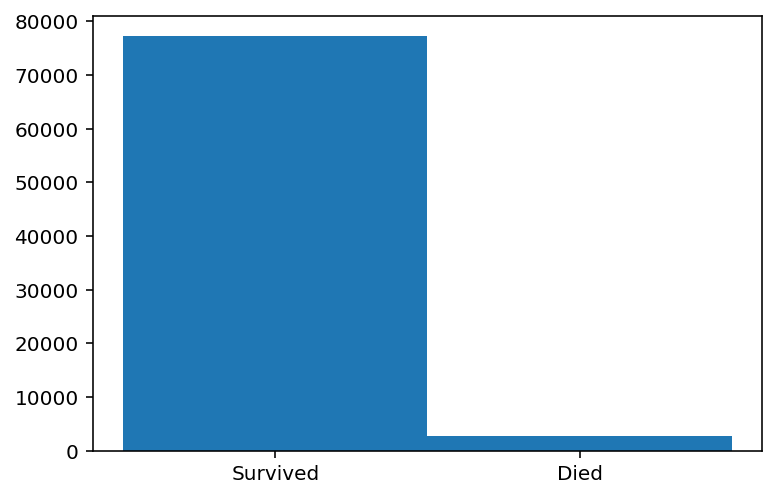

In [11]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

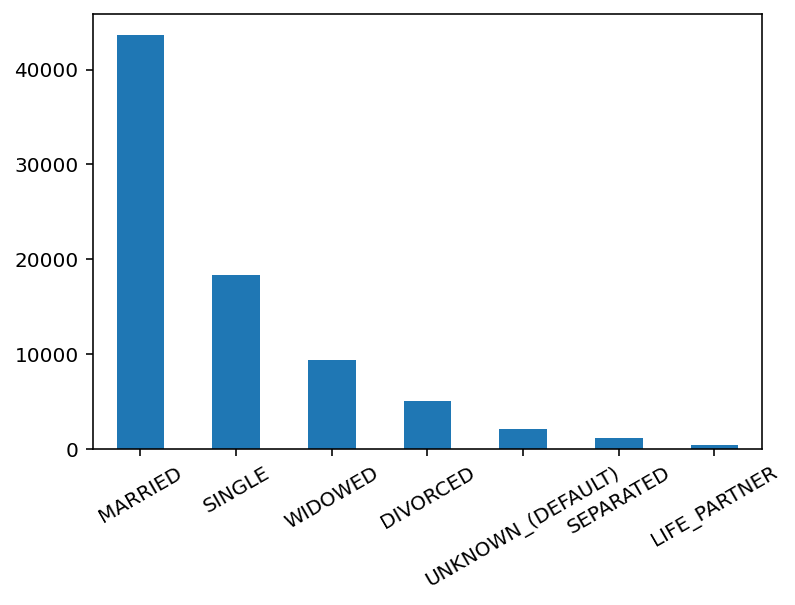

In [12]:
x_marital_cnts = x_df["MARITAL_STATUS"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

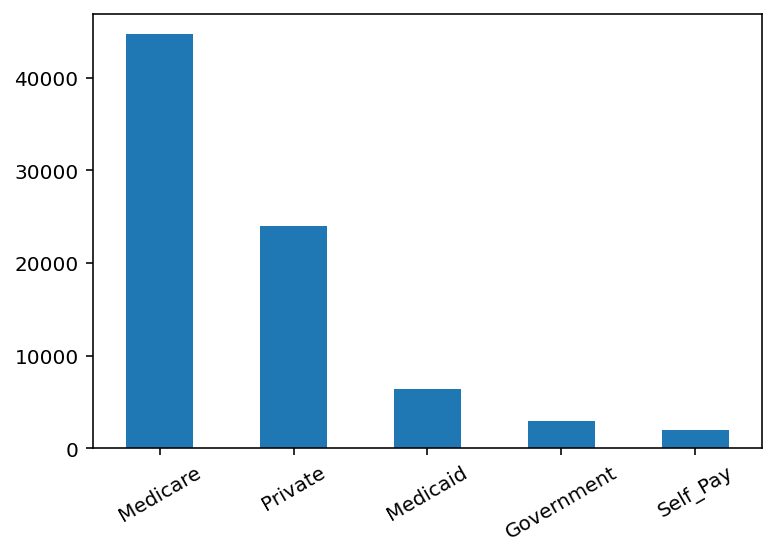

In [13]:
# TODO: Bar plot of another variable : INSURANCE

x_insurance_cnts = x_df["INSURANCE"].value_counts()
x_insurance_cnts.plot.bar(rot=30)
plt.show()

#### Correlations

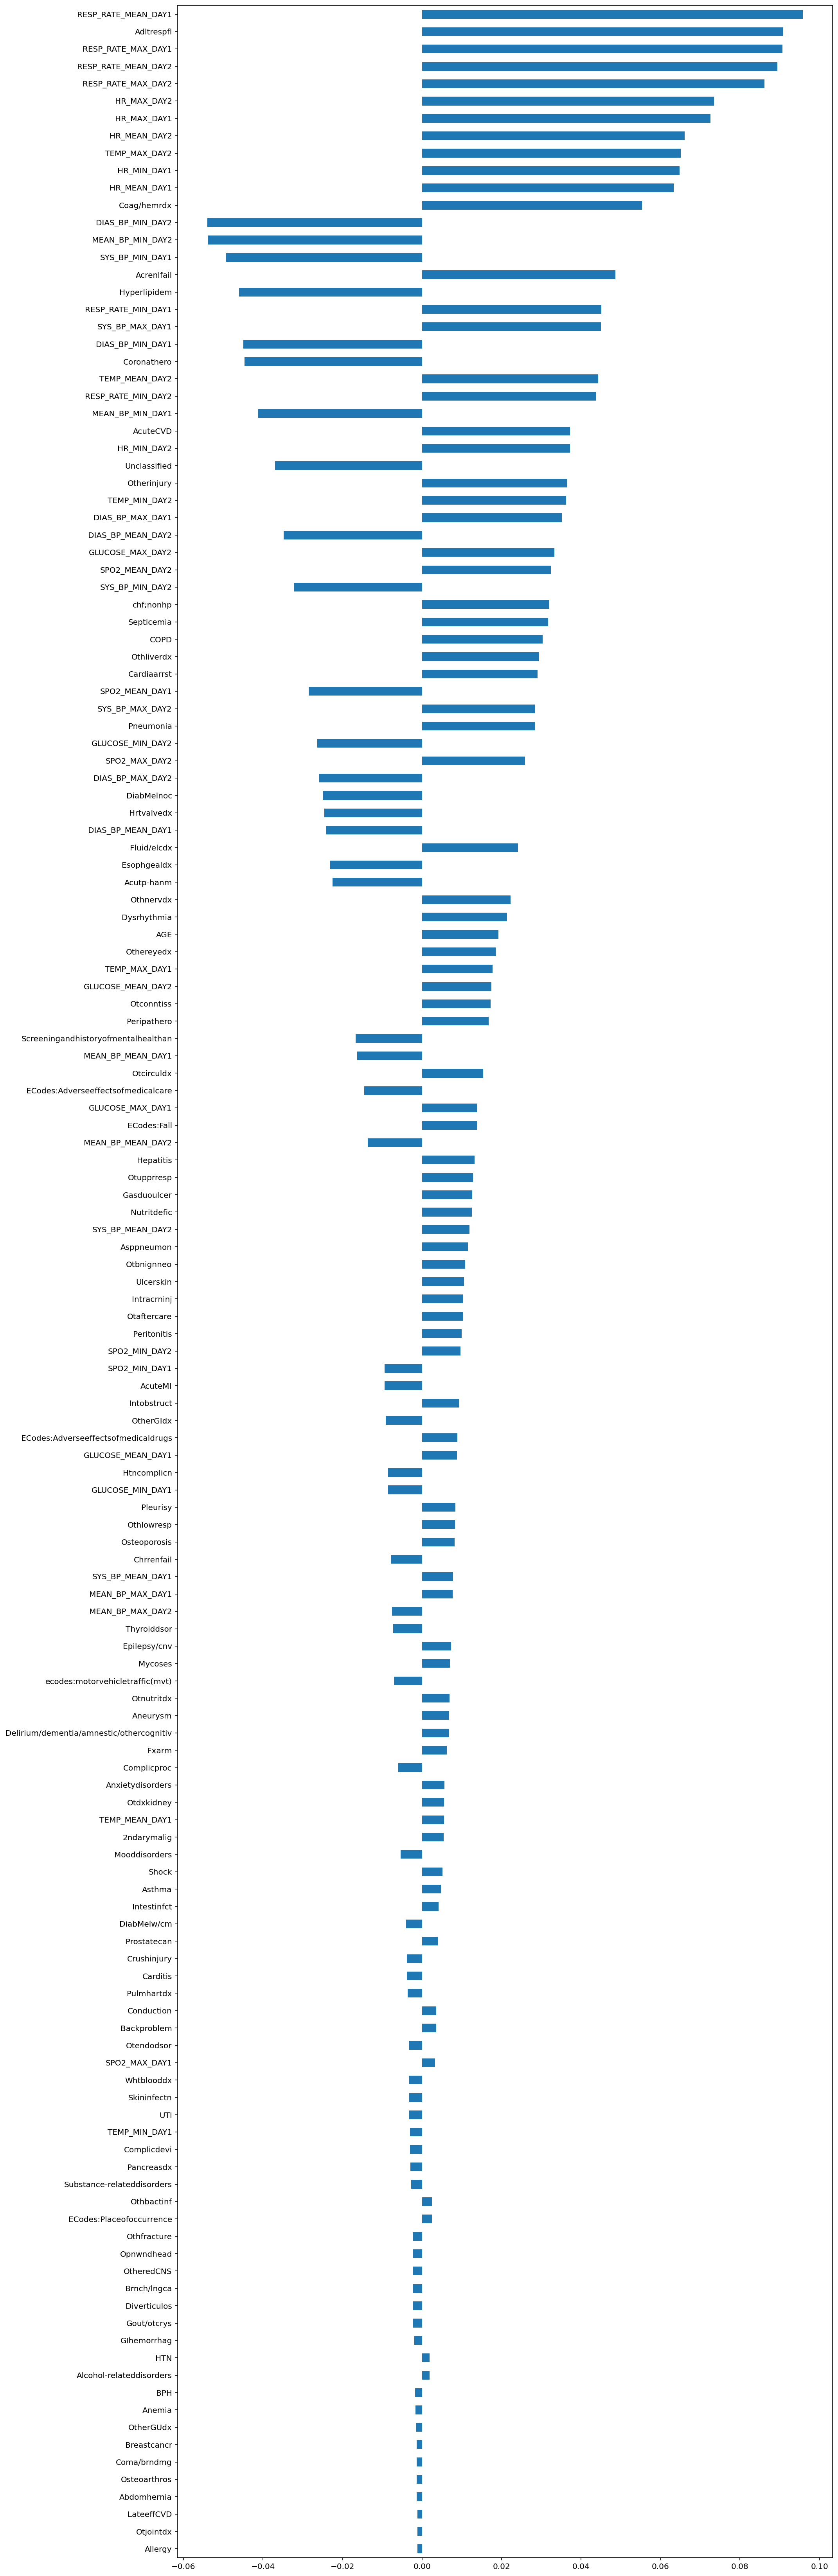

In [14]:
# TODO: Bar plot of the variables most correlated with y
s = x_df.corrwith(ys[:], axis=0)
s = s[abs(s)>0.001]
s = s.sort_values(key=lambda x: abs(x))
plt.figure(figsize=(15,60))
s.plot.barh(rot=0)
plt.show()

ces patients parlent majoritairement anglais, ainsi queune minorite espagnole et russe

on a certaine features qui n'ont pas de correlation avec ys

#### Autres graphiques ou r�sultats d'une analyse exploratoire

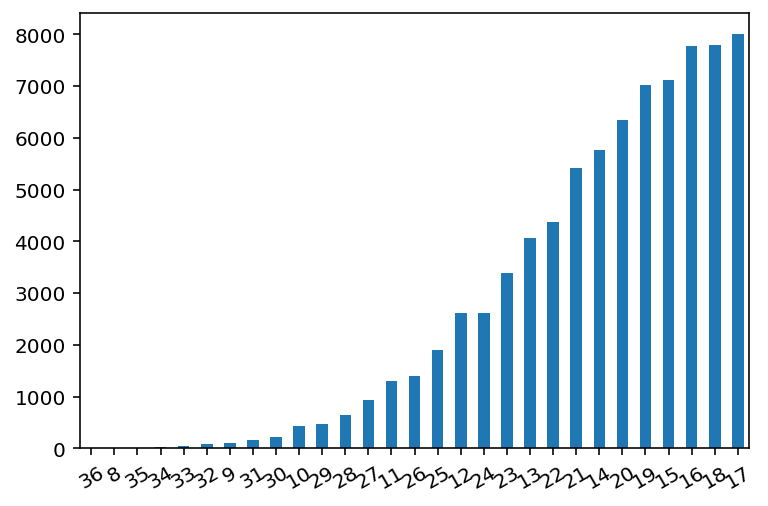

In [15]:
# TODO: Add graph
s = x_df.corrwith(ys, axis=0).idxmax()
x_df_copy = x_df.copy()
x_df_copy[s] = x_df_copy[s].round().astype(int)
x_highest_cnts = x_df_copy[s].value_counts().sort_values()
x_highest_cnts.plot.bar(rot=30)
plt.show()

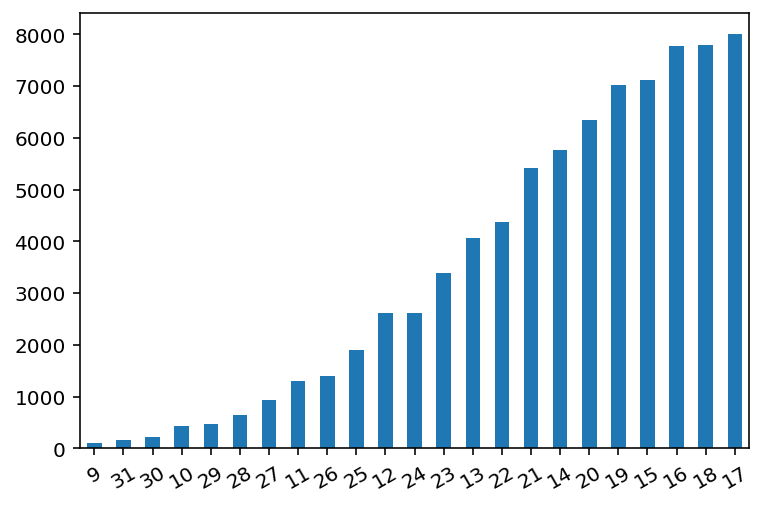

In [16]:
x_highest_cnts = x_df["RESP_RATE_MEAN_DAY1"].round().astype(int)
x_highest_cnts = x_highest_cnts.value_counts()
x_highest_cnts = x_highest_cnts[abs(x_highest_cnts)>100]
x_highest_cnts = x_highest_cnts.sort_values()
x_highest_cnts.plot.bar(rot=30)
plt.show()

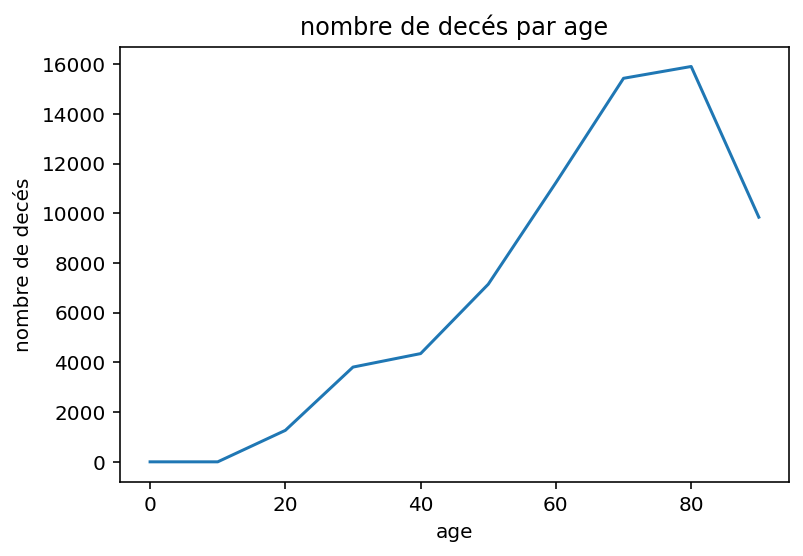

In [17]:
age = [i*10 for i in range(10)]
deathPerAge = []
for i in age: 
    agesdf = x_df['AGE'][x_df['AGE']<i]
    agesdf = agesdf[agesdf>i-10]
    indexes = agesdf.index
    deathPerAge.append(len(ys[indexes]==1))
plt.plot(age,deathPerAge)
plt.xlabel('age')
plt.ylabel('nombre de dec�s')
plt.title("nombre de dec�s par age")
plt.show()

on constate que l'ege des personnes decedees est majoritairement entre 40 ans et 80 ans, et cela nous aidera e prendre que les personne entre 40 et 80 ans pour le model 


## 4. Pre-traitement

### Code : Traitement du probl�me des valeurs manquantes (ou non d�finies, NAN)

La solution la plus simple est d'�liminer l'ensemble des colonnes o� il y a des donn�es manquantes, mais on perd de l'information. 

Vu le faible nombre d'instances concern�es (maximum 6 : voir ci-dessous) il parait plus pertinent de supprimer les lignes (instances) plut�t que les colonnes enti�res (variables).

La solution que nous choisissons ici est une troisi�me, celle de remplacer les valeurs non d�finies par la valeur la plus probable de la variable. Comme ces valeurs manquantes concernent exclusivement des variables cat�gorielles et binaires, la valeur la plus probable est le *mode* (voir cours : `part-5-slides.pdf`).

In [18]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


In [19]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [20]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]
x_test_miss

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

In [21]:
x_miss_rows = x_df.isna().any(axis="columns")

x_df.loc[x_miss_rows, x_miss.index]

,LANGUAGE,MARITAL_STATUS,ICU,ECodes:Adverseeffectsofmedicalcare,Otnutritdx,Othnervdx
2251,ENGL,MARRIED,MICU,NaN,0,0
9983,ENGL,MARRIED,MICU,0,NaN,0
10549,ENGL,MARRIED,MICU,0,NaN,0
10831,ENGL,MARRIED,MICU,NaN,1,0
17012,ENGL,MARRIED,CSRU,NaN,0,1
23088,ENGL,MARRIED,NaN,0,0,0
32539,ENGL,NaN,CSRU,0,0,0
42762,ENGL,SINGLE,TSICU,NaN,0,0
53191,NaN,MARRIED,MICU,0,0,0
53390,CAPE,MARRIED,NaN,0,0,0


#### Remplacement des NAN

In [22]:
na_cols = set(x_miss.index) | set(x_test_miss.index)

for col in na_cols:
    x_df[col].fillna(x_df[col].mode()[0], inplace=True)
    x_test_df[col].fillna(x_test_df[col].mode()[0], inplace=True)

In [23]:
print(
    x_df.isna().any().any(),
    x_test_df.isna().any().any(),
    sep="\n",
)

False
False


In [24]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


### Gestion des cat�gories rares

Simplifiez les donn�es en regroupant par exemple les cat�gories rares.

In [25]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


merge_rare_categories([x_df, x_test_df], col="RELIGION", keep_n=5)
print(x_test_df["RELIGION"].value_counts())

Index(['CATHOLIC', 'NOT_SPECIFIED', 'UNOBTAINABLE', 'PROTESTANT_QUAKER',
       'JEWISH'],
      dtype='object')
CATHOLIC             7517
NOT_SPECIFIED        3764
OTHER                2449
UNOBTAINABLE         2208
PROTESTANT_QUAKER    2208
JEWISH               1855
Name: RELIGION, dtype: int64


### Transformation des donn�es cat�gorielles en nombres entiers en utilisant deux types d'encodage

In [27]:
def label_encode(df, other_df, only_binary=False):

    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    # print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [28]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [29]:
print(x_df.shape, ys.shape)

(79999, 337) (79999,)


In [30]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [31]:
x_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0,0,0,0,0,0,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,2,1,1,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [32]:
x_test_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,3,0,5,3,0,0,18,72.6,113,96.5,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2,1,4,0,56,66.6,107,83.8,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,1,32,69.7,103,87.3,...,0,0,0,0,0,0,0,0,0,0


In [33]:
codes, uniques = pd.factorize(x_df["MARITAL_STATUS"])
cat2code = {k: v for v, k in enumerate(uniques)}
cat2code

{'DIVORCED': 0,
 'SINGLE': 1,
 'WIDOWED': 2,
 'MARRIED': 3,
 'UNKNOWN_(DEFAULT)': 4,
 'SEPARATED': 5,
 'LIFE_PARTNER': 6}

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [34]:
# Encode binary features on a single column (no need for 1-hot)
label_encode(x_df, x_test_df, only_binary=True)

x_all_oh_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_oh_df = x_all_oh_df.iloc[: len(x_df)].copy()
x_test_oh_df = x_all_oh_df.iloc[len(x_df):].copy()

print(x_df.shape, x_test_df.shape)
print(x_oh_df.shape, x_test_oh_df.shape)

(79999, 337) (20001, 337)
(79999, 463) (20001, 463)


#### Suppression des variables � valeur unique (constantes)

In [35]:
const_cols = {col for col in x_oh_df if len(x_oh_df[col].unique()) == 1}
len(const_cols)

173

In [36]:
x_oh_df.drop(const_cols, axis="columns", inplace=True)
x_test_oh_df.drop(const_cols, axis="columns", inplace=True)

print(x_oh_df.shape, x_test_oh_df.shape)

(79999, 290) (20001, 290)


### Cr�ation de l'ensemble de validation

In [37]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_oh_df, ys, test_size=0.3
)
# VARS: x_df, x_fact_df, x_oh_df

### R�duction de la dimension via l'ACP (PCA)

In [38]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]

na_cols = set(x_miss.index) | set(x_test_miss.index)

for col in na_cols:
    x_df[col].fillna(x_df[col].mode()[0], inplace=True)
    x_test_df[col].fillna(x_test_df[col].mode()[0], inplace=True)

In [39]:
x_all_oh_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_all_oh_df.apply(lambda x: pd.factorize(x)[0])

x_oh_df = x_all_oh_df.iloc[: len(x_df)].copy()
x_test_oh_df = x_all_oh_df.iloc[len(x_df):].copy()

In [40]:
correlated_features = set()
correlation_matrix = x_oh_df.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)


x_oh_df.drop(labels=correlated_features, axis=1, inplace=True)
x_test_oh_df.drop(labels=correlated_features, axis=1, inplace=True)

In [41]:
X = x_oh_df
Y = ys

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    X,
    Y,
    test_size=0.2
)

In [61]:
x_train_pca = preprocessing.StandardScaler().fit_transform(x_train)
pca_mod = decomposition.PCA(n_components=0.90)
xpca_train = pca_mod.fit_transform(x_train)
xpca_test = pca_mod.transform(x_test)
# je vois pas pourquoi ca marche pas la pca ici 

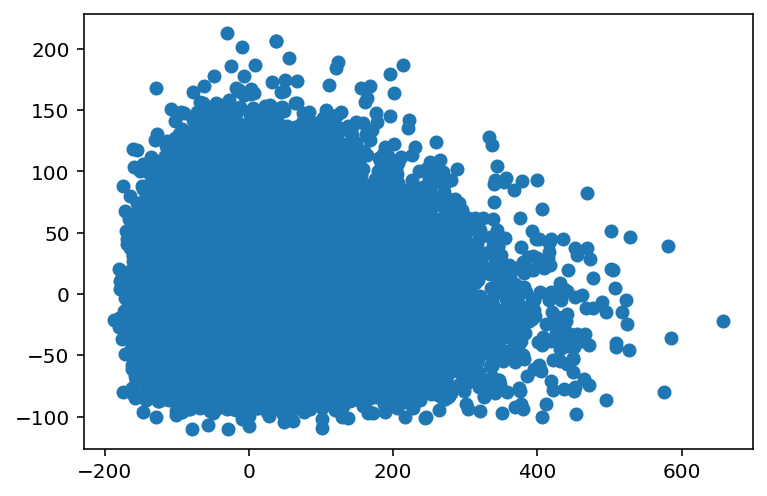

In [60]:
plt.scatter(xpca_train[:,0], xpca_train[:,1]) # a changer avec x_train_pca
plt.show()

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [44]:
SCORINGS = "balanced_accuracy"

In [65]:
Classifier ={
    "logisticRegression": linear_model.LogisticRegression(max_iter=1000),
    "random forest classifier": ensemble.RandomForestClassifier(n_estimators=10),
    "nearestCentroid":  neighbors.NearestCentroid(metric = 'euclidean', shrink_threshold=0.05),
    "gausianNB": naive_bayes.GaussianNB(),
    # "svm": svm.SVC(),
}


## 6. �valuations

In [66]:
accuracy_scores=np.zeros((118,2))

for index, nbc in enumerate(range(1, 119)):
    pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA(n_components = nbc)),
        ("resample", imblearn.over_sampling.SMOTE()),
        ('threshold', feature_selection.VarianceThreshold(threshold=0.01)),
        ("model", Classifier['logisticRegression'])
    ]
    )
    pipe.fit(x_train, y_train)
    pred_test_rbt = pipe.predict(x_test)
    resultat = metrics.balanced_accuracy_score(y_test, pred_test_rbt)
    accuracy_scores[index, 1]=( f"{resultat :.04f}")
    accuracy_scores[index, 0]=nbc

pd.DataFrame(accuracy_scores,columns=["nb_component","accuracy_score"]).sort_values(ascending = True, by=["accuracy_score"])

,nb_component,accuracy_score
0,1,0.57
1,2,0.575
2,3,0.604
3,4,0.606
5,6,0.619
...,...,...
117,118,0.697
92,93,0.699
101,102,0.699
111,112,0.699


In [67]:
pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("resample", imblearn.over_sampling.SMOTE()),
        ('threshold', feature_selection.VarianceThreshold(threshold=0.01)),
        ("model", Classifier['logisticRegression'])
    ]
)
pipe.fit(x_train, y_train)
pred_test_rbt = pipe.predict(x_test)
resultat = metrics.balanced_accuracy_score(y_test, pred_test_rbt)
print(f"Balanced accuracy score: {resultat:.3g}")

Balanced accuracy score: 0.734


In [68]:
CV = 10
cv = 2
SCORINGS = "balanced_accuracy"

In [69]:
#comparer les models : 
nbc_list = [10,100,150,170,177,180,183]
bacc_by_model=[]
for model in Classifier:
    bacc_by_nbc=[]
    for nbc in nbc_list:
        pipe = imblearn.pipeline.Pipeline(
        [
            ("scale", preprocessing.StandardScaler()),
            ("pca", decomposition.PCA(n_components = nbc)),
            ("resample", imblearn.over_sampling.SMOTE()),
            ('threshold', feature_selection.VarianceThreshold(threshold=0.01)),
            ("model",Classifier[model])
        ]
        )
        scores = model_selection.cross_val_score(pipe, X, Y, cv=2, scoring=SCORINGS)
        with np.printoptions(precision=2):
            bacc_by_nbc.append(scores)
    bacc_by_model.append(bacc_by_nbc)
bacc_by_model


[[array([0.636, 0.631]),
  array([0.693, 0.693]),
  array([0.7  , 0.703]),
  array([0.699, 0.71 ]),
  array([0.699, 0.713]),
  array([0.704, 0.712]),
  array([0.7  , 0.712])],
 [array([0.533, 0.527]),
  array([0.531, 0.531]),
  array([0.531, 0.528]),
  array([0.528, 0.522]),
  array([0.516, 0.526]),
  array([0.528, 0.528]),
  array([0.525, 0.524])],
 [array([0.629, 0.624]),
  array([0.683, 0.68 ]),
  array([0.681, 0.679]),
  array([0.684, 0.688]),
  array([0.687, 0.682]),
  array([0.686, 0.689]),
  array([0.687, 0.689])],
 [array([0.611, 0.603]),
  array([0.502, 0.497]),
  array([0.5  , 0.495]),
  array([0.499, 0.493]),
  array([0.5  , 0.493]),
  array([0.502, 0.491]),
  array([0.5  , 0.493])]]

In [70]:
# TODO: Cross-Validation

scores = model_selection.cross_val_score(pipe, x_oh_df, ys, cv=10, scoring=SCORINGS)

with np.printoptions(precision=2):
    print(scores)

print(f"\n{SCORINGS}: {scores.mean():.2f}, with std dev: {scores.std():.2f}\n")

[0.49 0.51 0.5  0.51 0.49 0.49 0.48 0.52 0.5  0.48]

balanced_accuracy: 0.50, with std dev: 0.01



In [80]:
bacc_by_model[0]
for model in Classifier:
    print(model)

logisticRegression
random forest classifier
nearestCentroid
gausianNB


logisticRegression


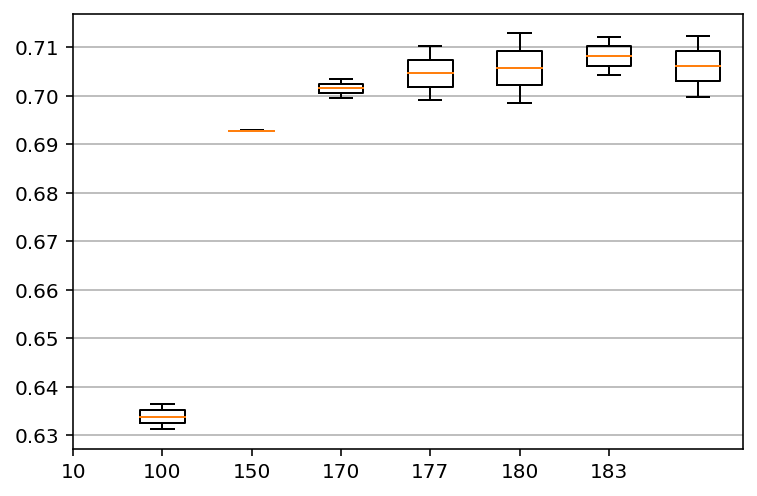

random forest classifier


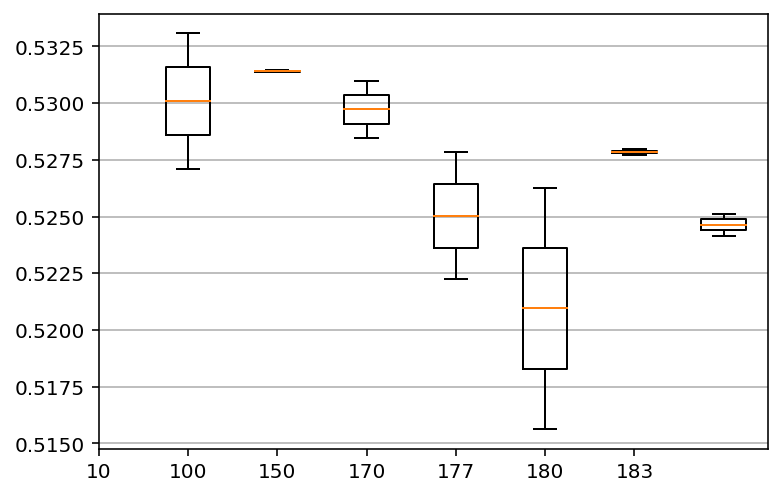

nearestCentroid


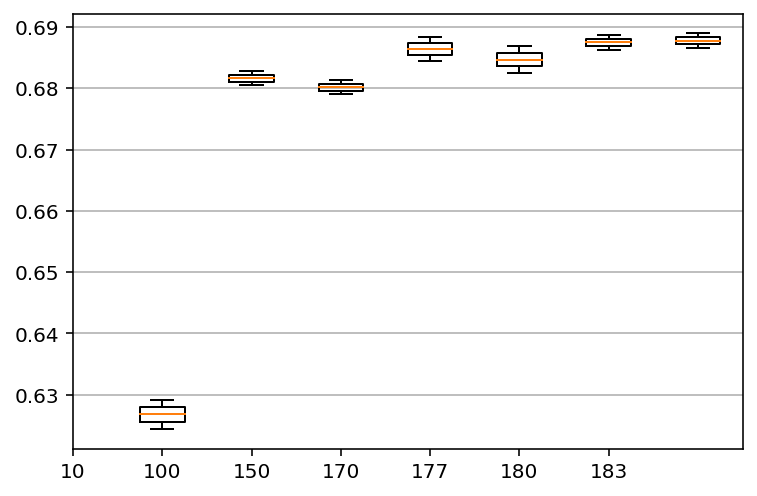

gausianNB


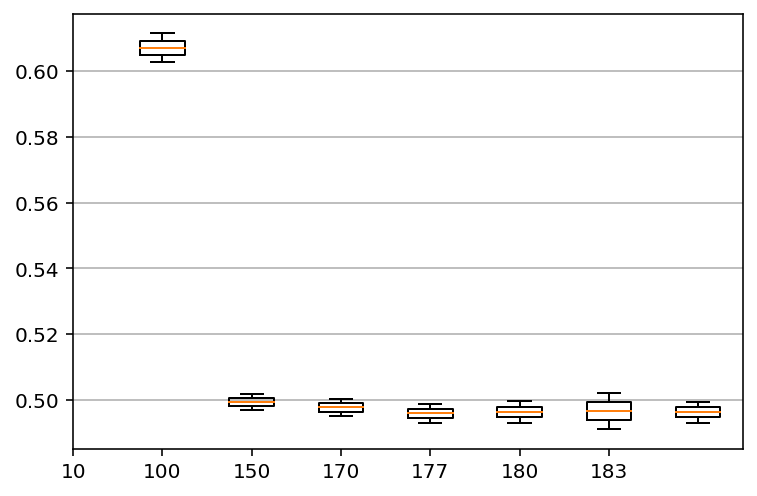

In [82]:
# TODO: Boxplot ou Barplot
i=0
for model in Classifier: # model names
    print(model) 
    plt.boxplot(bacc_by_model[i])
    plt.xticks([i  for i in range(len(nbc_list))], [str(nbc_list[i]) for i in range(len(nbc_list))])
    i+=1
    plt.grid(axis="y")
    plt.show()

on remarque que la moyen est au tour de 70%, meme en changeant le threshold 

In [73]:
# TODO: ROC 
# for the one model
metrics.roc_auc_score(y_test, pred_test_rbt)

0.7343356874274332

In [74]:
roc_as=[]
for model in Classifier:
    pipe = imblearn.pipeline.Pipeline(
        [
            ("scale", preprocessing.StandardScaler()),
            ("pca", decomposition.PCA(n_components = nbc)),
            ("resample", imblearn.over_sampling.SMOTE()),
            ('threshold', feature_selection.VarianceThreshold(threshold=0.01)),
            ("model",Classifier[model])
        ]
        )

    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)
    roc_as.append( metrics.roc_auc_score(y_test, y_pred))
    print(metrics.roc_auc_score(y_test, y_pred))
pd.DataFrame(roc_as,index=Classifier,columns=['roc_aus_score'])

0.6956028504777427
0.534093354211272
0.6838243909713567
0.4982099298032574


,roc_aus_score
logisticRegression,0.696
random forest classifier,0.534
nearestCentroid,0.684
gausianNB,0.498


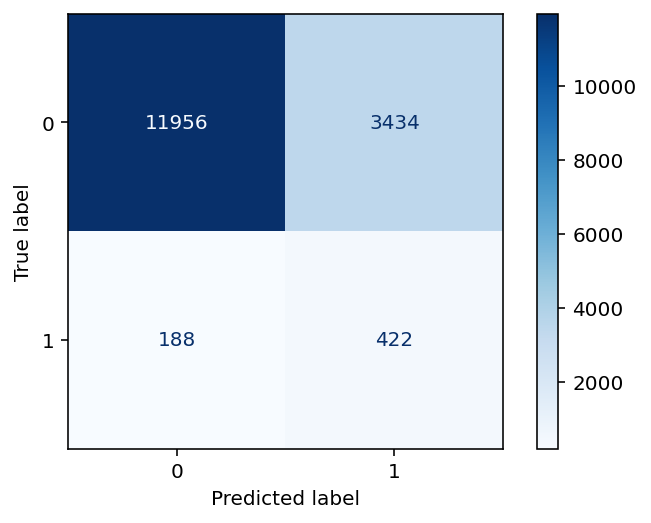

In [75]:

# TODO: Confusion Mtx
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, pred_test_rbt, cmap=plt.cm.Blues
)

on voit que le nombre de personnes pr�dites de vrais n�gatives sont de 12006, et 401 vrais positives, face � 3421 faux n�gatives et 172 faux positives, cette matrice nous montre que le mod�le est en conflit dans la pr�diction des vrais positives

Dans ce d�fi, nous avons atteint un r�sultat de 74 % dans le score de pr�cision �quilibr�.
Apr�s avoir t�l�charg� les donn�es, nous avons commenc� par la phase de pr�traitement o� nous avons supprim� certaines variables non corr�l�es et fusionn� d'autres, en fusionnant certaines variables et les convertant a des donn�es num�riques, nous avons ensuite commenc� � appliquer la technique PCA, une technique pour supprimer le bruit et r�duire la dimensionnalit� du jeu de donn�es.

apr�s la phase de pr�traitement, et diff�rentes analyses sur les donn�es, nous avons entra�n� le mod�le, avec plusieur classifiers, ceux-ci cependant, avaient conduit soit � seulement 50% de BalAccScore ou avaient pris des heures sans r�sultat, c'est pourquoi nous avons commenc� � filtrer les donn�es, en appliquant une technique de sur�chantillonnage, ainsi qu'en supprimant et en fusionnant davantage de features.

En ayant les donn�es pr�tes � �tre appliqu�es aux mod�les, nous avons utilis� un pipeline avec diff�rents hyperparam�tres choisis par la technique de validation crois�e, ces mod�les ont ensuite �t� compar�s les uns aux autres par leurs performances en utilisant la valeur ROC. o� finalement logistic Regression a �t� choisi, 4% mieux que les voisins.Nearest Centroid ,  8% mieux et 10min plus rapide que svc, qui �tait en troisi�me position

Si nous n'avions pas le temps, nous devrions utiliser hadoop qui facilite l'utilisation de toute la capacit� de stockage et de traitement des serveurs en cluster et l'ex�cution de processus distribu�s sur d'�normes quantit�s de donn�es. Hadoop fournit les blocs de construction sur lesquels d'autres services et applications peuvent �tre construits.




C'est une solution � un probl�me d'apprentissage automatique souvent pratique o� il y aura des diff�rences significatives dans la raret� des diff�rentes classes de donn�es pr�dites. Par exemple, lors de la d�tection de la mortalit� des patients, nous pouvons nous attendre � avoir des ensembles de donn�es avec un grand nombre de faux r�sultats et un nombre relativement plus petit de vrais r�sultats, comme nous l'avons ici dans notre cas.

Le sur�chantillonnage al�atoire consiste � s�lectionner au hasard des exemples de la classe minoritaire, avec remplacement, et � les ajouter � l'ensemble de donn�es d'apprentissage

Le sur�chantillonnage grace a la methode de sklearn imblearn.over_sampling.SMOTE est capable d'am�liorer le rapport de bruit et peut �tre utile pour �viter une compilation lente des mod�les. ainsi que pour compenser un d�s�quilibre qui est soit d�j� pr�sent dans les donn�es, soit susceptible de se d�velopper si un �chantillon purement al�atoire �tait pr�lev�

In [77]:
# pipe = imblearn.pipeline.Pipeline(
#     [
#         ("scale", preprocessing.StandardScaler()),
#         ("pca", PCA()),
#         ("resample", imblearn.over_sampling.SMOTE()),
#         ('threshold', feature_selection.VarianceThreshold(threshold=0.01)),
#         ("model", model)
#     ]
# )
# pipe.fit(x_oh_df, ys)

# predictions = pipe.predict(x_test_oh_df)  # compute predictions
# # VARS: x_test_df, x_test_fact_df, x_test_oh_df, x_test_1hot_pcs
# # Models: model, search


# PRED_PATH.mkdir(parents=True, exist_ok=True)

# t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
# submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

# pred_fname = "mimic_synthetic_test.csv"
# compr_opts = dict(method="zip", archive_name=pred_fname)

# pd.Series(predictions).to_csv(
#     submission_fp, compression=compr_opts, index=False, header=False
# )

# print(f"The submission is ready: {submission_fp}")

---

---